## Track an Object in 3D Space

_Saminda Abeyruwan_

The objective of the project is to use to keypoint detectors, descriptors, and methods to match objects  between 
successive images. We detect objects in an image using the YOLO deep-learning framework, and associate regions in a 
camera image with Lidar points in 3D space.

We develop:
1. methodologies to match 3D objects over time by using keypoint correspondences, 
2. compute the TTC based on Lidar measurements,
3. compute the TTC using the camera, which requires to first associate keypoint matches to regions of interest and 
then to compute the TTC based on those matches, and, 
4. conduct various tests with the framework. 

Our goal is to identify the most suitable detector/descriptor combination for TTC estimation and also to search for 
problems that can lead to faulty measurements by the camera or Lidar sensor. 

The dataset used in the analysis is available in [stats_output.csv](stats_output.csv).

#### FP.1: Match 3D Objects

We implement the method _matchBoundingBoxes_, which takes as input both the previous and the current data frames 
and provides as output the ids of the matched regions of interest. We use matches with the highest number of 
keypoint correspondences.

<img src="match_bb.png" width="779" height="414" /> 

As the figure shows, first, we associate the corresponding DMatch pairs in the
the previous (query) frame to the bounding boxes. Each bounding box has a region-of-interest (roi)
field set, and we can use CV API to find the inclusive keypoints. Second, we find in the current (train)
frame, which bounding boxes has the matching keypoint. As shown in the figure, not all keypoints
from query frame match to a single train frame. We select the train bounding box that contains the most
number of matching pairs.

<img src="gt_vs_pred.png" width="779" height="414" />
 
There are 18 query-train image pains in the dataset. We have a set of utility methods to identify the bounding box ID 
of the ROI in the ego lane. We can track these box IDs overtime which provides the ground truth. If our matched or
predicted box IDs are correct, they should follow the same box ID sequence. The figure above shows that our predictions
are 100% match with the ground truth for the ego lane (this is using our best keypoint detector/descriptor combination). 

#### FP.2 : Compute Lidar-based TTC

We have calculated the time-to-collision (TTC) for all matched 3D objects based on Lidar measurements. We have used
the theory presented in the lectures to obtain the constant velocity TTC. In order to obtain robust estimation (which
is not sensitive to outliers), we have used _median_ distance.

#### FP.3 : Associate Keypoint Correspondences with Bounding Boxes

We have found all keypoint matches from query to train frames simply checking whether the corresponding keypoints are 
within the region of interest in the camera image. In order to reduce outliers,  we  compute a robust mean and 
standard deviation of all the euclidean distances between keypoint matches and then remove those that are two standard 
deviation the mean. 

#### FP.4 : Compute Camera-based TTC 

We have calculated the TTC for all matched 3D objects based on Camera measurements. We have used
the theory presented in the lectures to obtain the constant velocity TTC. In order to obtain robust estimation we have 
used _median_ distance ratios.

#### FP.5 : Performance Evaluation 1

With the given thresholds and median based distance and distance ratio calculation, for the best performing model, 
we have observed the TTC is between 8 to 15 seconds. Based on manual investigation, these TTCs look reasonable. 

But, there are keypoint detector/descriptor combinations that both Lidar and Camera based estimated TTC is way off
(Performance Evaluation 2). Our bounding box tracking is highly dependent on the keypoints and their associations. If
the association are off, the corresponding TTC estimation are off as well. We have used the same set of thresholds
across all the detector/descriptor combinations. In order to obtain better performance, we need to optimize and
experiment with all the thresholds, which we have not conducted in this project. 

#### FP.6 : Performance Evaluation 2 
  
We have used FAST, BRISK, ORB, AKAZE, and SIFT detectors and BRIEF, ORB, FREAK, AKAZE and SIFT descriptors. 
The matching configuration has been fixed. We have used the FLANN approach with the descriptor distance ratio set 
to 0.8. We have not used HARRIS detector, as it has been the worst performing (kepoint extraction time-wise) detector.
We were not able to produce results for SIFT x BRIEF detector and descriptor combination.

In [20]:
import numpy as np
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

In [21]:
df = pd.read_csv("stats_output.csv")

In [22]:
def tidy_df(df):
    """Tidy dataset from df."""
    df["graph"] = df["det"] + "_x_" + df["des"]
    df = df.replace([np.inf, -np.inf], 0.0)
    df_lidar = df.copy()
    df_camera = df.copy()
    df_lidar["ttc"] = df["ttc_lidar"]
    df_lidar["type"] = "lidar"
    df_camera["ttc"] = df_camera["ttc_camera"]
    df_camera["type"] = "camera"
    
    df_lidar = df_lidar[["img_idx", "ttc", "type", "graph"]]
    df_camera = df_camera[["img_idx", "ttc", "type", "graph"]]
    
    return df_lidar.append(df_camera, ignore_index=True)

In [23]:
df_all = tidy_df(df)

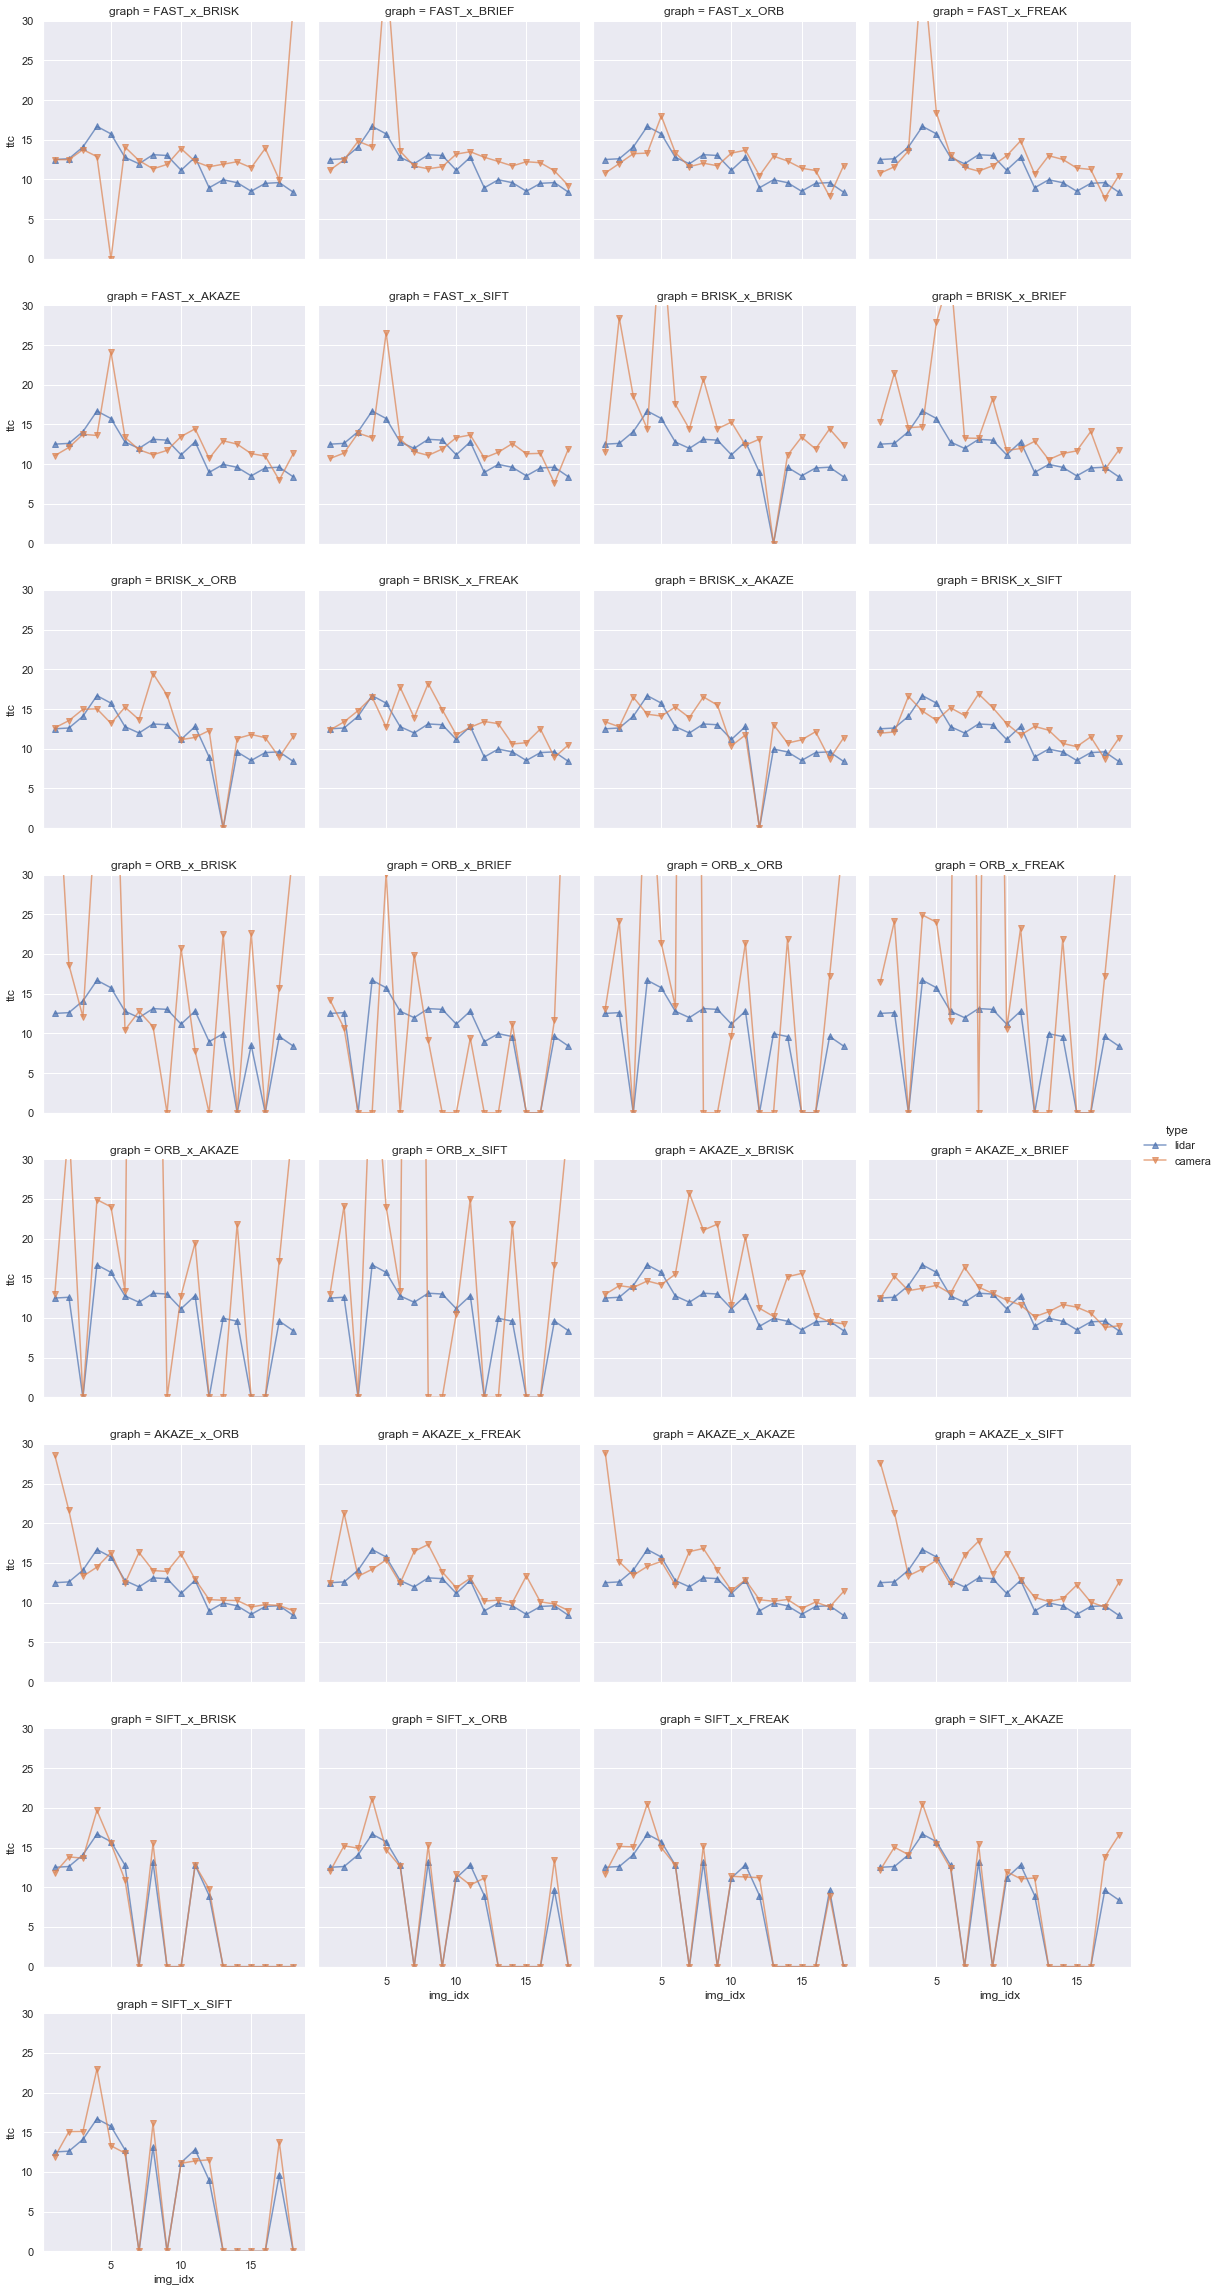

In [24]:
g = sns.FacetGrid(df_all, col="graph", hue="type", hue_kws=dict(marker=["^", "v"]), col_wrap=4, ylim=(0, 30), height=4)
g.map(plt.plot, "img_idx", "ttc", alpha=.7)
g.add_legend();

Based on our implementation and experiments, the best performing detector/descriptor combinations are:

1. AKAZE x BRIEF
2. BRISK x SIFT
3. FAST x ORB

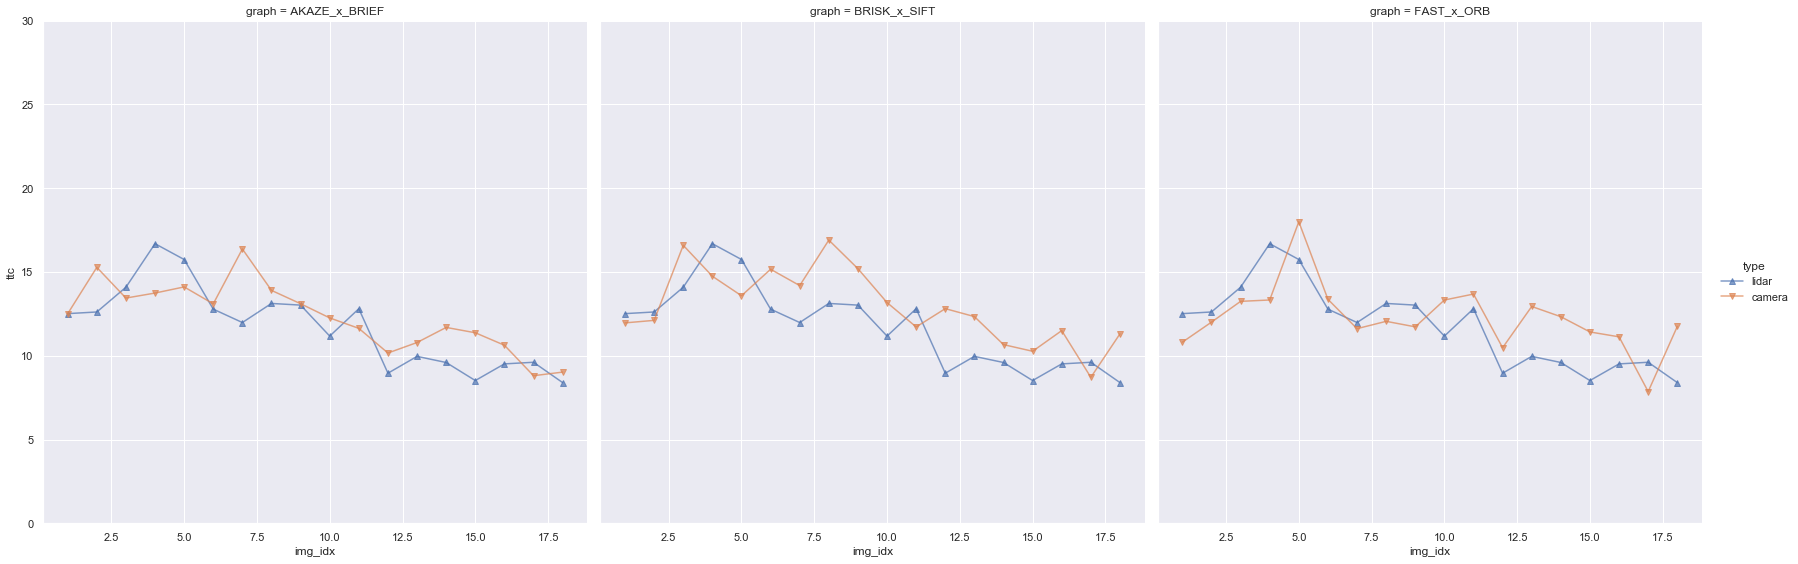

In [41]:
df_selected = df_all.query("graph=='AKAZE_x_BRIEF' or graph=='BRISK_x_SIFT' or graph=='FAST_x_ORB'")
g_selected = sns.FacetGrid(df_selected,
                           col="graph", 
                           hue="type", 
                           hue_kws=dict(marker=["^", "v"]),  
                           ylim=(0, 30), 
                           height=8, col_order=["AKAZE_x_BRIEF", "BRISK_x_SIFT", "FAST_x_ORB"])
g_selected.map(plt.plot, "img_idx", "ttc", alpha=.7)
g_selected.add_legend();
